# Phase-flip code

In this notebook, I am going to implement the phase-flip error-detecting and error-correcting code via *qiskit* library. 

## I. Introduction of Background Knowledge
The phase-flip noise here is a single qubit noise and the corresponding noise channel is given by
\begin{equation}
\mathcal{N}(\rho) = (1-p)\mathbf{I}\rho + p \mathbf{Z}\rho \mathbf{Z}
\end{equation}

Usually, we are only interested in correction of one qubit with arbitrary quantum state and we will also use the repetition code in the phase-flip error correction. Since the $Z$ error has the following property,
\begin{equation}
Z|0\rangle = |0\rangle, Z|1\rangle = -|1\rangle, Z|+\rangle = |-\rangle, Z|-\rangle = |+\rangle,
\end{equation}
in this case, we need to encode state $|\psi\rangle = a|0\rangle + b|1\rangle$ with following rules

\begin{equation}
|+_L\rangle = |+++\rangle, |-_L\rangle = |---\rangle. 
\end{equation}

Similarly, the phase-flip error correction will follow the procedure below:
* Encode $|\psi\rangle$ into repetition form, $|\psi_L\rangle = a|+++\rangle + b|---\rangle$
* (Noise happen)
* Specify the noise with the help of syndrome from stabilizer. 
* Recover the noise with syndrome measurement result
* Decode $|\psi_L\rangle$ and re-generate $|\psi\rangle = a|0\rangle + b|1\rangle$

Note that if we only consider one qubit $Z$ error, and if we encode $|\psi\rangle$ state into $|\psi_L\rangle = a|000\rangle + b|111\rangle$, the resulting state after $ZII$, $IZI$ and $IIZ$ error will be always $a|000\rangle - b|111\rangle$, which does not have any quantum property (and it is a classical error). We can use one of the following recovery, $ZII$, $IZI$ or $IIZ$, to fix the noisy signal, but I still follow the error correction procedure to correct the mistake. 

In the following sections, I will provide details of each steps and construct the corresponding circuit. 

In [1]:
# Import require package
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, IBMQ
from qiskit.visualization import plot_histogram
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

## II. The Procedure of Phase-Flip Noise Correction
In this section, I will describe details of how to finish 5 steps of phase-flip noise correction. 

### A. Encoding
The encoding process that transfer $|\psi\rangle=a|0\rangle+b|1\rangle$ into repetition form, $|\psi_L\rangle = a|+++\rangle + b|---\rangle$ is shown below. We use the CNOT gate to generate the entangled state and Hadmard gate to transfer $|0\rangle$ and $|1\rangle$ into $|+\rangle$ and $|-\rangle$. The two ancilla qubits will be used to detect error in the future. 

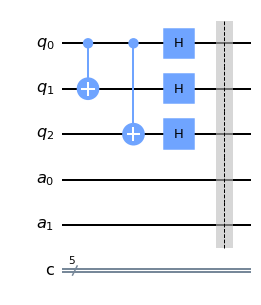

In [2]:
# Construct quantum circuit
qreg_q = QuantumRegister(3, 'q')
qreg_a = QuantumRegister(2, 'a')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, qreg_a, creg_c)

# Encoding
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.h(qreg_q[0:3])
circuit.barrier()
circuit.draw()

### B. Error Detection
In the phase-flip noise case, we consider three kinds of single-qubit error, $ZII$, $IZI$ and $IIZ$. We need to specify which error happens and thus perform the corresponding recovery. The stabilizer code formulism will be helpful to build the detection code and specify error with syndrome. The stabilizer of phase-flip code is 
\begin{equation}
\mathcal{S} = \{ XXI,IXX\}.
\end{equation}
Note that we have

\begin{equation}
X|+\rangle = |+\rangle, X|-\rangle = -|-\rangle.
\end{equation}
Thus, the corresponding syndrome for different error types is given by

| Error  |  $S_1$  | $S_2$     |
| :----:       |   :----:  |  :----: |
| No Error   |  +1       | +1   |
|  $ZII$   | -1      | +1     |
|  $IZI$  | -1      | -1     |
|  $IIZ$  | +1      | -1     |

The following gate would be used to detect the eigenvalue of $Z$ operation in practice. 

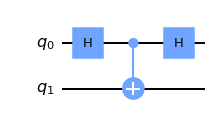

In [3]:
# Detect eigenvalue of X
tmp = QuantumCircuit(2)
tmp.h(0)
tmp.cx(0,1)
tmp.h(0)
tmp.draw()

Phase-flip correcting code requires two stabilizers, $XXI$ and $IXX$, thus the error detecting circuit can be constructed as follow. Note that the error detecting code would not break the coherence of $|\psi_L\rangle=a|+++\rangle+b|---\rangle$ while detecting the error. Equivalently, the first three Hadmard gate transfer the encoding state into $a|000\rangle+b|111\rangle$, and the following detecting code is the same as bit-flip code. If we re-consider the error detection and recovery part, we will have two equivalent ways to achieve our goal
* Method 1: Transfer the $|\psi_L\rangle=a|+++\rangle+b|---\rangle$ into $|\psi_L\rangle=a|000\rangle+b|111\rangle$ code, and follow the bit-flip error correcting procedure, which means in recovery part we will perform $X$ gate for correction. 
* Method 2: Still measure the eigenvalue of stabilizer $XXI$ and $IXX$, and correct the error by $Z$ gates

In both **Error Detection** and **Recovery the Noise** part, we will implement the two methods. In the detection part, the only difference is the Hadmard gates after CNOT detections. 

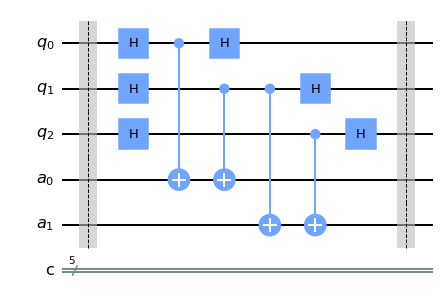

In [4]:
# Step 1 Detection
qreg_q = QuantumRegister(3, 'q')
qreg_a = QuantumRegister(2, 'a')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, qreg_a, creg_c)

# Error Detection Circuit
circuit.barrier()
circuit.h(qreg_q)
circuit.cx(qreg_q[0], qreg_a[0])
circuit.cx(qreg_q[1], qreg_a[0])
circuit.cx(qreg_q[1], qreg_a[1])
circuit.cx(qreg_q[2], qreg_a[1])
circuit.h(qreg_q)
circuit.barrier()
circuit.draw()

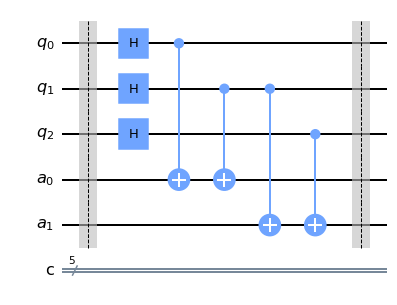

In [5]:
# Step 2 Detection
qreg_q = QuantumRegister(3, 'q')
qreg_a = QuantumRegister(2, 'a')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, qreg_a, creg_c)

# Error Detection Circuit
circuit.barrier()
circuit.h(qreg_q)
circuit.cx(qreg_q[0], qreg_a[0])
circuit.cx(qreg_q[1], qreg_a[0])
circuit.cx(qreg_q[1], qreg_a[1])
circuit.cx(qreg_q[2], qreg_a[1])
circuit.barrier()
circuit.draw()

### C. Recover the Noise
According to the table of syndrome, we can construct recovery circuits for two methods to correct one of three possible error. In practice, for the $Z$ correction, control-$Z$ gate is used to detect the $-1$ eigenvalue (or $|1\rangle$) state, and the multi-control-$Z$ gate is used to detect and correct, e.g., $IZI$ error. Qiskit does not have multi-control-$Z$ gate and we decide to *use the Hadmard gate and Toffoli gate to make it*. The recovery circuit is shown below, respectively.

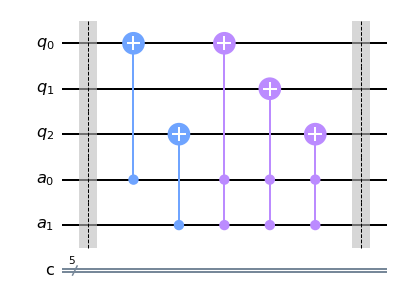

In [6]:
# Step 1 Recovery, the same as bit-flip code
qreg_q = QuantumRegister(3, 'q')
qreg_a = QuantumRegister(2, 'a')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, qreg_a, creg_c)

# Recovery
circuit.barrier()
circuit.cx(qreg_a[0], qreg_q[0])
circuit.cx(qreg_a[1], qreg_q[2])
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[0])
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[1])
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[2])
circuit.barrier()
circuit.draw()

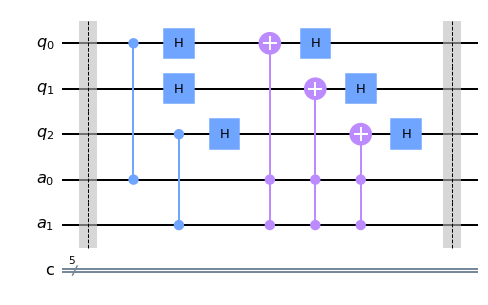

In [7]:
# Step 2 Recovery, use the control-Z gate to correct the error
qreg_q = QuantumRegister(3, 'q')
qreg_a = QuantumRegister(2, 'a')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, qreg_a, creg_c)

# Recovery
circuit.barrier()
circuit.cz(qreg_a[0], qreg_q[0])
circuit.cz(qreg_a[1], qreg_q[2])
circuit.h(qreg_q)
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[0])
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[1])
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[2])
circuit.h(qreg_q)
circuit.barrier()
circuit.draw()

### D. Decoding the Resulting State
Remember that we encode 1 qubit information into a 3-qubits state to protect it from the bit-flip error, thus we need to recover the initial input state, or decode the resulting state. The decoding process is simply the inverse of encoding process, namely,

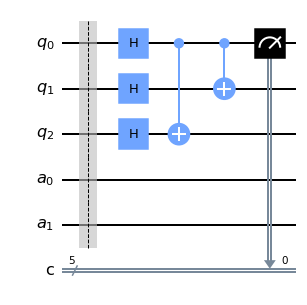

In [8]:
# Construct quantum circuit
qreg_q = QuantumRegister(3, 'q')
qreg_a = QuantumRegister(2, 'a')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, qreg_a, creg_c)

# Decoding
circuit.barrier()
circuit.h(qreg_q)
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.measure(qreg_q[0], creg_c[0])
circuit.draw()

## III. Test the Method
With detail description in each subsection, in this part, I combine 5 steps together and construct a complete circuit. Note that the bit-flip part has been test in the bit-flip error correcting jupyter-notebook file, so I focus on the Method 2 and see whether it would work.

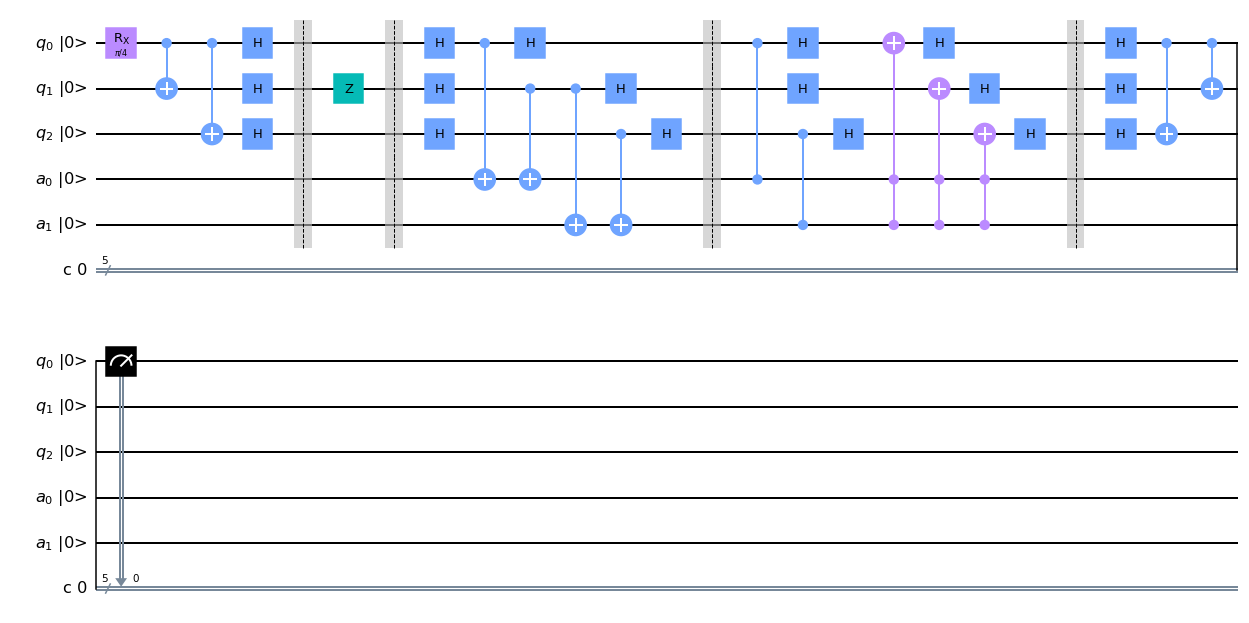

In [9]:
qreg_q = QuantumRegister(3, 'q')
qreg_a = QuantumRegister(2, 'a')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, qreg_a, creg_c)

# Initialize
circuit.rx(np.pi/4, 0)

# Encode
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.h(qreg_q[0:3])

# Noise
circuit.barrier()
circuit.z(qreg_q[1])
circuit.barrier()

# Detect
circuit.h(qreg_q)
circuit.cx(qreg_q[0], qreg_a[0])
circuit.cx(qreg_q[1], qreg_a[0])
circuit.cx(qreg_q[1], qreg_a[1])
circuit.cx(qreg_q[2], qreg_a[1])
circuit.h(qreg_q)
circuit.barrier()

# Recover
circuit.cz(qreg_a[0], qreg_q[0])
circuit.cz(qreg_a[1], qreg_q[2])
circuit.h(qreg_q)
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[0])
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[1])
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[2])
circuit.h(qreg_q)
circuit.barrier()

# Decode
circuit.h(qreg_q)
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.measure(qreg_q[0], creg_c[0])

circuit.draw(initial_state=True)

In the circuit above, I initialize the input state with rotation-x gate (with rotation angle as $\pi/4$) and adopt error $IZI$. To check whether the code works well, we need to compare the result of input and output state. The input state counts is given by 

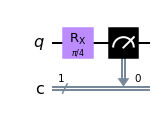

In [10]:
ini = QuantumCircuit(1, 1)
ini.rx(np.pi/4, 0)
ini.measure(0, 0)
ini.draw()

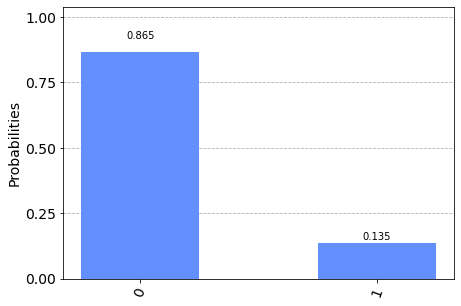

In [11]:
sim = Aer.get_backend('aer_simulator')
result = sim.run(ini).result()
counts = result.get_counts()
plot_histogram(counts)

The output state is then given by the following code. After comparison, one can easily conclude that the error correcting code works well. 

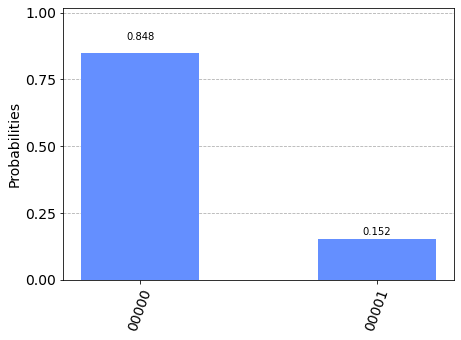

In [12]:
result = sim.run(circuit).result()
counts = result.get_counts()
plot_histogram(counts)